# A dashboard for exploring MA-XRF data 

In [ ]:
#| default_exp dashboard 

Given our precomputed `.datastack` files present in our Nextcloud storage we can now visualize our MA-XRF data in a Dashboard viewer after downloading them once. 

::: {.callout-warning} 

The total size of these 16 files is pretty big (56.5 GB) and downloading on my computer took about half an hour! 

:::

In [14]:
#|code-fold: true 
from fairdatanow import DataViewer
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle 
import os
import numpy as np 
import moseley as mos 
import maxrf4u as mx
import re 
import imageio as iio

from falnama import get_roi_ims

In [2]:
#|code-fold: true 
configuration = {
    'url': "https://laboppad.nl/falnama-project", 
    'user':    os.getenv('NC_AUTH_USER'),
    'password': os.getenv('NC_AUTH_PASS')
}

In [3]:
filters = {'extensions': ['.datastack']} 

dv = DataViewer(configuration, **filters)
datastack_files = dv.download_filtered() 

Ready with downloading 16 selected remote files to local cache: /home/frank/.cache/fairdatanow                                                                      


Ok, let's start our exploration by plotting a thumbnail overview of all scanned areas. 

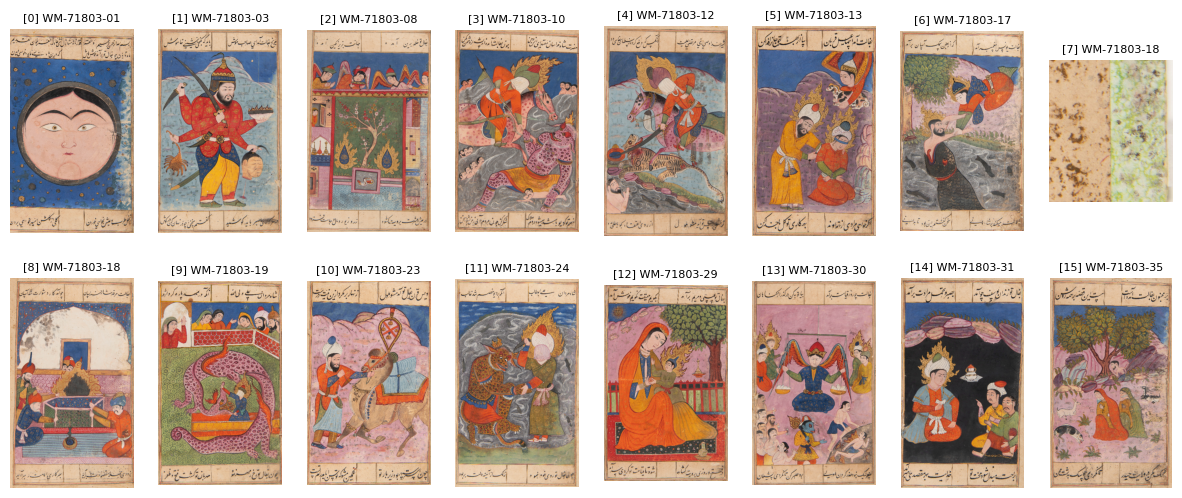

In [4]:
imvis_list = []
extent_list = []
for datastack_file in datastack_files: 
    ds = mx.DataStack(datastack_file)
    im = ds.read('imvis_reg')
    extent = ds.read('imvis_extent')
    imvis_list.append(im)
    extent_list.append(extent)

object_nums = [re.sub(r'.*(WM-71803-\d\d).*', r'\1', dsf) for dsf in datastack_files]

fig, axs = plt.subplots(ncols=8, nrows=2, figsize=[15, 6])
axs = axs.flatten()
for i, [im, ax, extent] in enumerate(zip(imvis_list, axs, extent_list)): 
    ax.imshow(im, extent=extent)
    ax.set_title(f'[{i}] {object_nums[i]}', fontsize=8)
    ax.axis('off')

## Solving the sulfur situation

It came as a shock to me today that my two sulfur maps (i.e. a slice map and an NMF map) **both are worse than the Bruker map**. 

In [5]:
filters = {'search': '.*Results/04.*71803-35_S.tif', 'use_regex': True}   
dv = DataViewer(configuration, **filters)
bruker_sulfur_tif = dv.download_filtered()[0]

Ready with downloading 1 selected remote files to local cache: /home/frank/.cache/fairdatanow                                                                      


In [6]:
bruker_S_map = plt.imread(bruker_sulfur_tif)

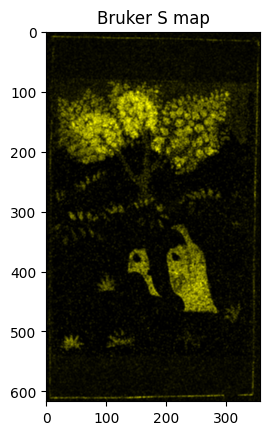

In [7]:
fig, ax = plt.subplots()
ax.imshow(bruker_S_map)
ax.set_title('Bruker S map');

### Parse datastack 

A first step now is to read relevant datasets from the datastack file and  manually select regions of interest for page 35 (index 15)...

In [8]:
n = 15
datastack_file = datastack_files[n]
ds = mx.DataStack(datastack_file)

object_num = object_nums[n]

cube = ds.read('maxrf_cube', compute=False)
imvis_highres = ds.read('imvis_reg_highres')
imvis = ds.read('imvis_reg')
extent = ds.read('imvis_extent')
x_keVs = ds.read('maxrf_energies')
y_maxspectrum = ds.read('maxrf_maxspectrum')

nmf_elementmaps = ds.read('nmf_elementmaps') 

#ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file, tube_keV=23)
ppa = mos.PeakPatternAtlas(x_keVs=x_keVs) 


ds.tree()

Ready building Peak Pattern Atlas!                                                                   


/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (31, 4096) float64
├── hotmax_noiselines (31, 4096) float64
├── hotmax_peak_idxs_flat (34,) int64
├── hotmax_peak_idxs_list (31, 2) int64
├── hotmax_spectra (31, 4096) float32
├── hotmax_spots (31, 2) int64
├── hotmax_subpeak_idxs_list (31, 18) int64
├── imvis_extent (4,) int64
├── imvis_reg (617, 357, 3) uint8
├── imvis_reg_highres (8256, 4777, 3) uint8
├── maxrf_cube (617, 357, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 617, 357) float32
├── nmf_gausscomponents (35, 4096) float32
├── nmf_peakmaps (35, 617, 357) float32
└── nmf_peaks2elements_matrix (18, 34) float32

/home/frank/.cache/fairdatanow/falnama-project/OPENDATA/maxrf/datastacks/WM-71803-35_400_500_50.datastack:




In [6]:
# broken... 
# mx.get_instrument_pattern(datastack_file)

In [9]:
%matplotlib widget

### Regions of interest and their elements 

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=[20, 15])
axs = axs.flatten()
for ax in axs: 
    ax.imshow(imvis_highres, extent=extent)

xylims_list = [[int(ax.get_xlim()[0]), int(ax.get_xlim()[1]), int(ax.get_ylim()[0]), int(ax.get_ylim()[1])] for ax in axs]

In [10]:
xylims_list = [[29, 51, 106, 84], [39, 88, 136, 91], [154, 183, 242, 208], [275, 296, 249, 227], [40, 59, 289, 269],
               [72, 124, 441, 397], [146, 168, 462, 443], [139, 161, 393, 370], [245, 268, 454, 433], [197, 219, 300, 278]]

roi_ims = get_roi_ims(datastack_file, xylims_list)

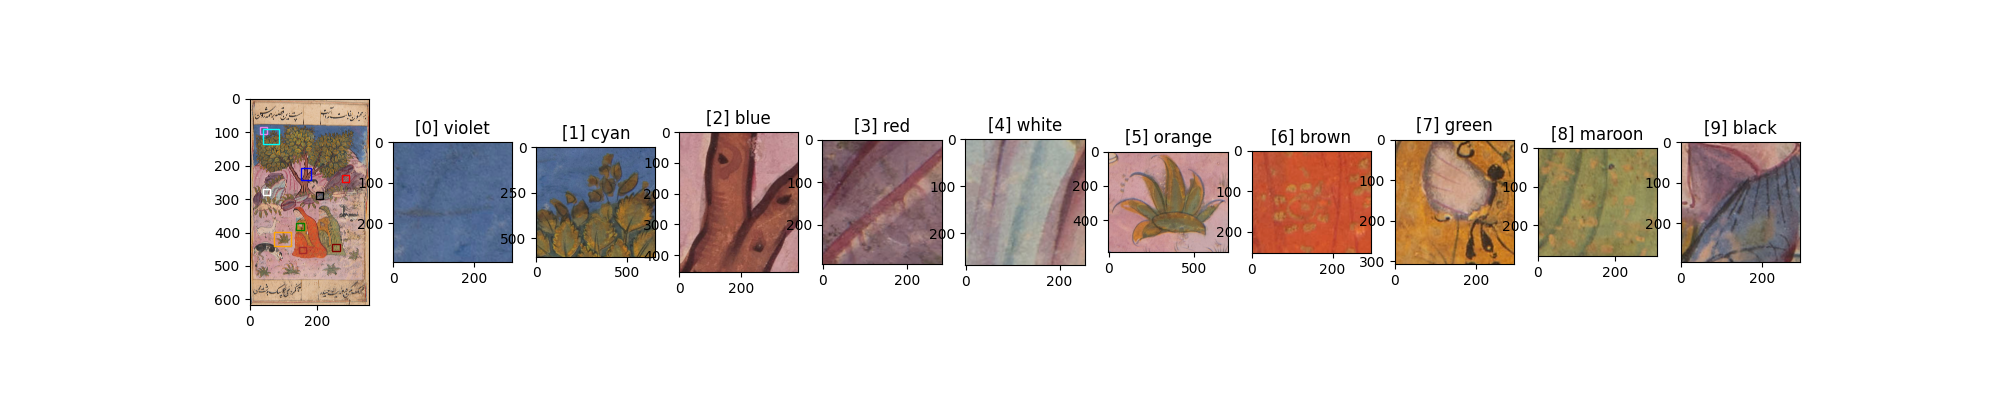

In [15]:
fig, axs = plt.subplots(ncols=len(roi_ims)+1, figsize=[20, 4], squeeze=True)

edgecolors = ['violet', 'cyan', 'blue', 'red', 'white', 'orange', 'brown', 'green', 'maroon', 'black']

axs[0].imshow(imvis_highres, extent=extent)

for i, xylims in enumerate(xylims_list):
    x0, x1, y0, y1 = xylims
    axs[0].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))

for i, [ax, im] in enumerate(zip(axs[1:], roi_ims)): 
    
    ax.imshow(im)
    ax.set_title(f'[{i}] {edgecolors[i]}')

### Matplotlib houtje-touwtje dashboard 

Here is the latest still very rough code for an ROI tabs dashboard. 

In [95]:
plt.close('all')

Ok, we now need some pretty advanced ROI hotmax functionality. Ehm, let's build that here from scratch... 

In [16]:
import falnama as fn

In [17]:
###### BUILD DASHBOARD FIGURES CANVAS ################### r

roi_elements_list = [['Pb', 'K', 'Ca', 'Fe'], #0 We see clear peaks for K and Ca in the spectrum and slice maps why is Ca not showing clearly in the Ca (NMF) map?
                     ['Pb_1', 'K', 'Ca', 'As_1', 'S'], #1
                     ['Pb', 'Fe', 'Ca', 'Hg'], #2
                     ['Pb', 'Pb_1', 'S'], #3
                     ['Pb', 'Fe', 'Ca'], #4
                     ['Pb', 'As', 'S', 'Fe'], #5 Here we see that the NMF maps are more clear the the alpha slices
                     ['Au', 'Pb', 'As'], #6 Clearly gold on red lead. The Pb alpha slice map is confusing, no Hg present in the Au  
                     ['Pb', 'As', 'S', 'Au'], #7 The yellow robe is clearly orpiment. Here again the the overlapping Pb alpha with As is confusing 
                     ['As', 'S', 'Au', 'Pb'], #8 According to the NMF map there should be no lead present in the green robe 
                     ['Pb']] #9

roi_cubes = [cube[l:k, i:j].compute() for i, j, k, l in xylims_list] 
roi_ims = get_roi_ims(datastack_file, xylims_list)


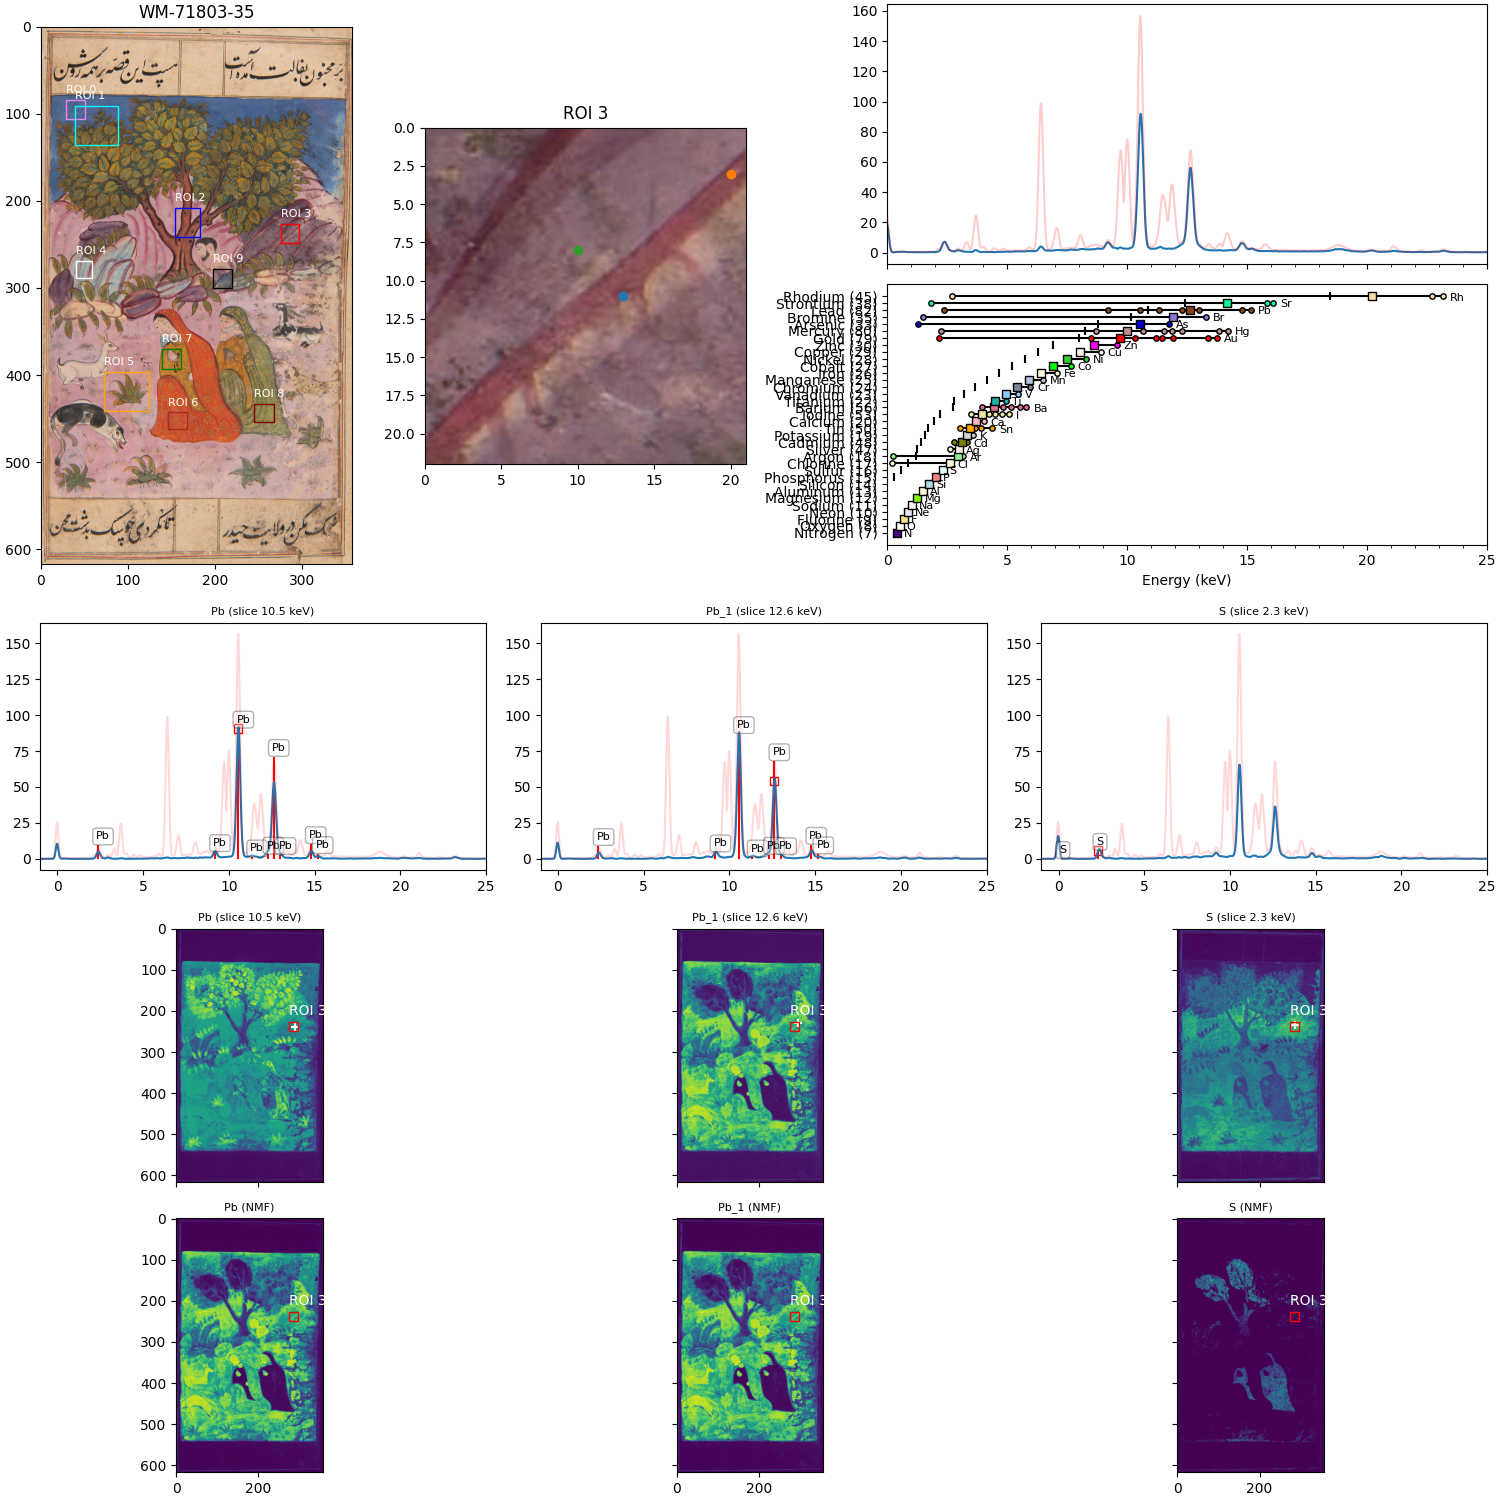

In [19]:
roi_n = 3
ncols = len(roi_elements_list[roi_n])
hspace = 0.02
wspace = 0.02 
xylims = xylims_list[roi_n]
l, r, b, t = xylims 
w = r - l 
h = b - t 
roi_extent = [0, w, h, 0]
 
fig = plt.figure(layout='constrained', figsize=(15, 15))
topfigs, midfig, botfig = fig.subfigures(nrows=3, hspace=hspace, height_ratios=[2, 1, 2], squeeze=True) 
topleftfig, topmidfig, toprightfig = topfigs.subfigures(ncols=3, wspace=wspace, width_ratios=[1, 1, 2], squeeze=True) 

ax_00 = topleftfig.subplots()
ax_01 = topmidfig.subplots()
ax_020, ax_021 = toprightfig.subplots(nrows=2, squeeze=True, sharex=True)

spectra_axs = midfig.subplots(ncols=ncols, squeeze=True, sharex=True) #, sharey=True) 

maps_axs = botfig.subplots(nrows=2, ncols=ncols, sharex=True, sharey=True)


########## TOP #################

# RGB overview and RGB ROI 
ax_00.imshow(imvis_highres, extent=extent)
for i, xylims in enumerate(xylims_list):
    x0, x1, y0, y1 = xylims
    ax_00.add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))
    ax_00.annotate(f'ROI {i}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=8)
    
ax_00.set_title(object_num)


ax_01.imshow(roi_ims[roi_n], extent=roi_extent) 
ax_01.set_title(f'ROI {roi_n}')

# ROI spectral plots and peek pattern atlas 

# compute roi cube (core) maxspectrum 
hotmax_idxs, spectra = get_hotmax_spectra(roi_cubes[roi_n])
roi_cube = roi_cubes[roi_n]
roi_h, roi_w, roi_d = roi_cube.shape
roi_flat = roi_cube.reshape([-1, roi_d])
roi_maxspectrum = roi_flat.max(axis=0) # actually this is the roi core max spectrum  
roi_elements = roi_elements_list[roi_n]

ax_020.plot(x_keVs, roi_maxspectrum, label='ROI maxspectrum')
ax_020.plot(x_keVs, y_maxspectrum, color='r', alpha=0.2, label='full page maxspectrum')
ax_020.set_xlim([-1, 25])
ax_021.set_xlabel('energy [keV]')
#ax_020.legend() # need to fix blocking of view 

# plot peak pattern atlas 
select_elems = roi_elements_list[roi_n]
select_elems = [re.sub('_.*', '', elem) for elem in select_elems]

ppa.plot_atlas(ax=ax_021)


for i, element in enumerate(roi_elements): 

    # based on element now compute element slice map and related hotmax properties 
    slice_map, slice_idx = get_slice_map(datastack_file, element)
    hx, hy, roi_x, roi_y, hotmax_spectrum = get_roi_slice_hotmax(datastack_file, slice_idx, xylims_list[roi_n]) 

    # add hotmax locations to TOP image plots 
    ax_01.scatter(roi_x, roi_y)

    # add slice line to spectral plots 
    #spectra_axs[i].axvline(x_keVs[slice_idx], color='r')

    # add hotmax locations to slice maps 
    maps_axs[0, i].scatter(hx, hy, color='w', marker='+')
    
    # add hotmax spectra and element shadows to mid figure
    spectra_axs[i].plot(x_keVs, hotmax_spectrum)
    spectra_axs[i].scatter(x_keVs[slice_idx], hotmax_spectrum[slice_idx], marker='s', edgecolor='r', facecolor='none')
    #plot_element_shadow(element, x_keVs, flip=1, ax=spectra_axs[i], y=hotmax_spectrum)

    spectra_axs[i].plot(x_keVs, y_maxspectrum, color='r', alpha=0.15)
    spectra_axs[i].set_xlim([-1, 25])
    spectra_axs[i].set_title(f'{element} (slice {x_keVs[slice_idx]:.1f} keV)', fontsize=8)
    
    plot_element_lines(element, x_keVs, ax=spectra_axs[i], color='r', y=hotmax_spectrum)
    
    # add NMF map for element 
    nmf_map =  pick_nmf_elementmap(datastack_file, nmf_elementmaps, element) 
    
    maps_axs[0, i].imshow(slice_map)
    maps_axs[0, i].set_title(f'{element} (slice {x_keVs[slice_idx]:.1f} keV)', fontsize=8)
    maps_axs[1, i].imshow(nmf_map)
    maps_axs[1, i].set_title(f'{element} (NMF)', fontsize=8)

    # add ROI rectangle 
    x0, x1, y0, y1  = xylims_list[roi_n]
    maps_axs[0, i].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[roi_n], facecolor='none'))
    maps_axs[0, i].annotate(f'ROI {roi_n}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=10)
    maps_axs[1, i].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[roi_n], facecolor='none'))
    maps_axs[1, i].annotate(f'ROI {roi_n}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=10)


### Can we fit a lead layer thickness? 

Ok, Let's extract a global hotmax spectrum for `Pb_1`  

In [20]:
Pb_slice_map, Pb_slice_idx = get_slice_map(datastack_file, 'Pb_1')
yi, xi = np.argwhere(Pb_slice_map == Pb_slice_map.max())[0] 
Pb_hotmax = cube[yi, xi, :].compute()


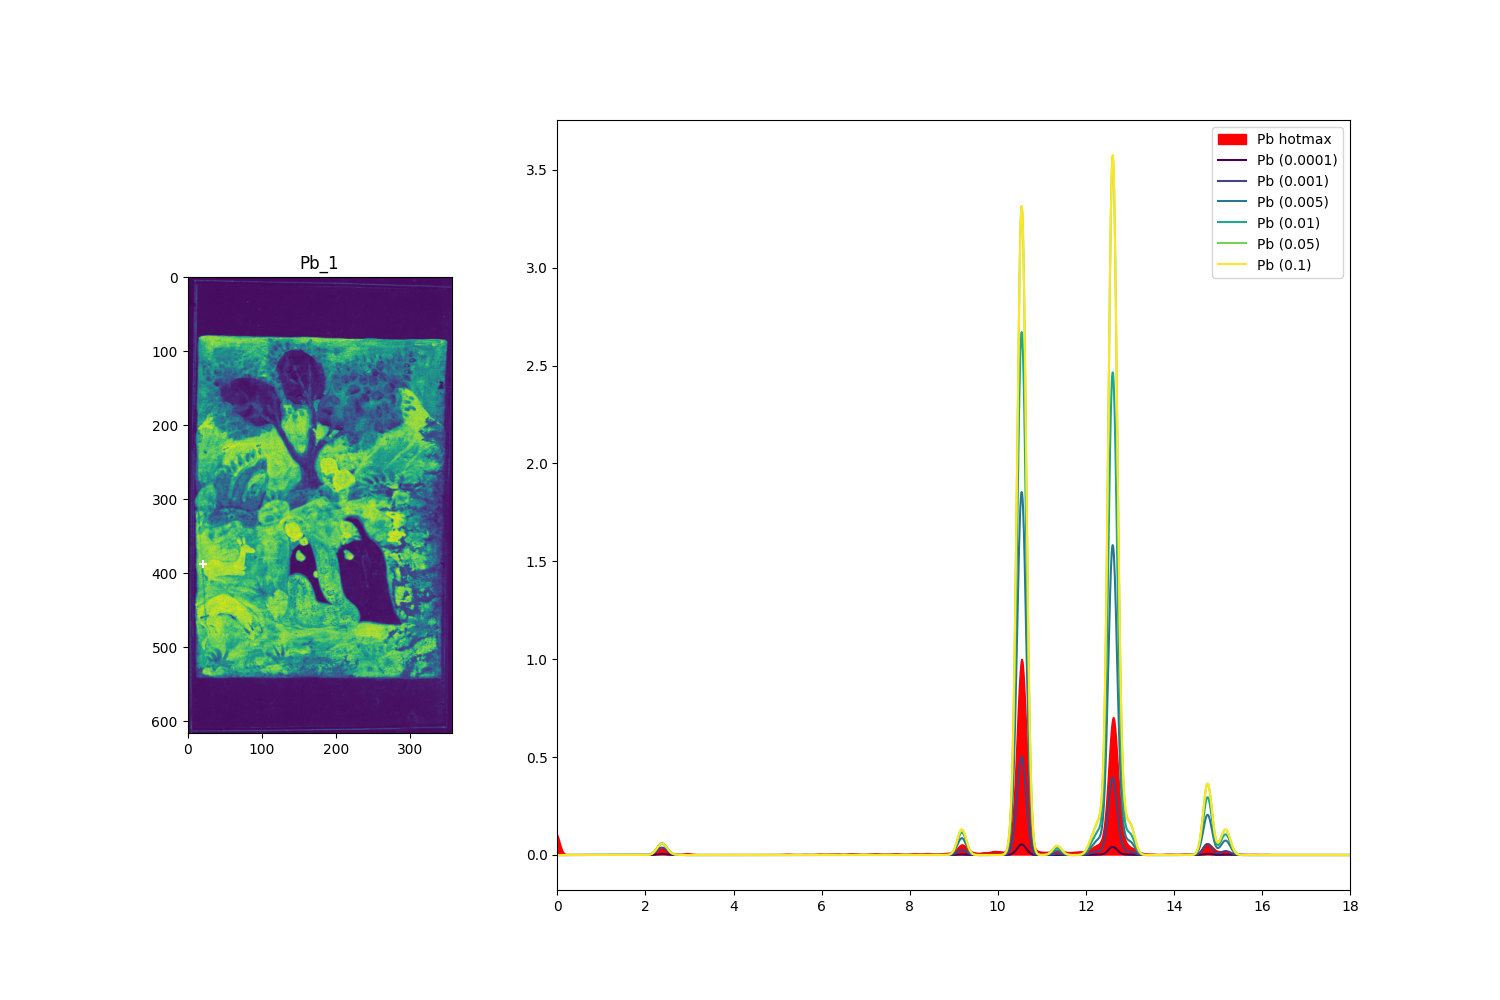

In [67]:
fig, axs = plt.subplots(ncols=2, figsize=[15, 10], width_ratios=[1, 3])
ax0, ax1 = axs.flatten()

ax0.imshow(Pb_slice_map)
ax0.scatter(xi, yi, color='w', marker='+')
ax0.set_title('Pb_1')

ax1.fill_between(x_keVs, Pb_hotmax / Pb_hotmax.max(), color='r', label='Pb hotmax')

h_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1] 

colors = cm.viridis(np.linspace(0, 1, len(h_list)))

for i, h_mm in enumerate(h_list): 
    
    Pb_xrf = mos.ElementXRF('Pb', h_mm=h_mm, excitation_energy_keV=30, x_keVs=x_keVs, std=0.02)
    Pb_x, Pb_y = Pb_xrf.spectrum_xy
    
    ax1.plot(Pb_x, 100*Pb_y, color=colors[i], label=f'Pb ({h_mm})')
    ax1.legend()
    ax1.set_xlim([0, 18]);

I need to have access to the peak indexes... 

In [65]:
Pb_xrf.get_pattern_dict()

{'elem': 'Pb',
 'atomic_number': 82,
 'alpha_keV': 12.609790734147028,
 'name': 'Lead',
 'peaks_xy': array([[1.26097907e+01, 3.57595202e-02],
        [1.05442700e+01, 3.31442037e-02],
        [1.47655527e+01, 3.64028035e-03],
        [1.51666247e+01, 1.29834767e-03],
        [9.18062517e+00, 1.29593281e-03],
        [2.37242804e+00, 5.87008945e-04],
        [1.13464139e+01, 4.67320502e-04]]),
 'alpha_escape_keV': 10.869790734147028}

## FUNCTIONS 

In [12]:
#|export 

import falnama as fn
import matplotlib.pyplot as plt
import maxrf4u as mx  
import moseley as mos
import numpy as np
import scipy.signal as ssg 
import matplotlib.cm as cm
import skimage.exposure as ske
from matplotlib.patches import Rectangle 
import re
from ipywidgets import widgets 

In [13]:
#|export 

elem_colors = {'Pb': 'k', 'Au': 'orange', 'Fe': 'brown', 'Ca': 'g', 'K': 'b', 'As': 'magenta', 'Na': 'blue', 'Ni': 'red', 'Cu': 'green', 'Ti': 'blue', 'Zn': 'red'} 

def get_roi_slice_hotmax(datastack_file, slice_idx, xylims): 
    '''Find full map and roi coordinates (x, y, roi_x, roi_y)  of slice map maximum at channel `slice_idx` within ROI `xylims`.
    
    Returns: x, y, roi_x, roi_y, hotmax_spectrum 
    '''
    ds = mx.DataStack(datastack_file)
    cube = ds.read('maxrf_cube', compute=False)
    
    slice_map = cube[:,:,slice_idx].compute()
    i, j, k, l = xylims 
    roi_slice_map = slice_map[l:k,i:j]
    
    roi_y, roi_x = np.argwhere(roi_slice_map == roi_slice_map.max()).flatten()
    x = roi_x + i
    y = roi_y + l 

    hotmax_spectrum = cube[y, x, :].compute()

    return x, y, roi_x, roi_y, hotmax_spectrum
    

def plot_roi_peak_patterns(roi_cube, prominence=2, ax=None): 
    '''Plot patterns of the roi cube hotmax spectra.'''

    hotmax_idxs, spectra = get_hotmax_spectra(roi_cube)
    
    peak_idxs_list = []
    for y in spectra: 
        peak_idxs = ssg.find_peaks(y, prominence=2)[0] 
        peak_idxs_list.append(peak_idxs)

    if ax is None: 
        fig, ax = plt.subplots()

    for i, peak_idxs in enumerate(peak_idxs_list): 
        
        peak_idxs = peak_idxs[1:] # get rid of instrument peak at zero

        ones = np.ones_like(peak_idxs)

        ax.scatter(x_keVs[peak_idxs], (len(peak_idxs_list) - i) * ones)
        ax.plot(x_keVs[peak_idxs], (len(peak_idxs_list) - i) * ones)
        
    return peak_idxs_list 


def get_hotmax_spectra(roi_cube): 
    '''Get hotmax spectra for `roi_cube`. 
    
    Returns: `hotspot_idxs, `spectra` 
    '''

    hotmax_idxs = []
    spectra = []
    
    n_channels = roi_cube.shape[-1]
    y_max = roi_cube.reshape([-1, n_channels]).max(axis=0) 
    peak_idxs = ssg.find_peaks(y_max, prominence=1)[0] 
    
    
    for p_i in peak_idxs: 
        peak_slice = roi_cube[:,:, p_i]
        i, j = np.argwhere(peak_slice == peak_slice.max())[0]
   
        y = roi_cube[i, j]
        
        spectra.append(y)
        hotmax_idxs.append([int(i), int(j), int(p_i)])

    hotmax_idxs = np.array(hotmax_idxs)

    return hotmax_idxs, spectra 


def plot_hotmax_spectra(spectra, x_keVs, hotmax_idxs, elems=None, xlim=[-1, 22], elem_colors=elem_colors, y_maxspectrum=None):
    '''Plot roi hotmax spectra and add emission lines for list of elements `elems`. 

    Returns: axs 
    '''

    peak_idxs = hotmax_idxs[:, 2] 
    
    fig, axs = plt.subplots(nrows=len(spectra), sharex=True, sharey=True, figsize=[20, 20], squeeze=True, layout='compressed')
    
    for i, y in enumerate(spectra): 
        axs[i].set_xlim(xlim)
        if y_maxspectrum is not None: 
            axs[i].plot(x_keVs, y_maxspectrum, color='r', alpha=0.1)
        axs[i].plot(x_keVs, y, label=f'#{i}')
        axs[i].scatter(x_keVs[peak_idxs[i]], y[peak_idxs[i]], marker='s', color='r')
        axs[i].legend()
    
        if elems is not None: 
            for elem in elems: 
            
                plot_element_lines(elem, y=y, ax=axs[i], x_keVs=x_keVs, color=elem_colors[elem])

    return axs    

def get_element_lines(element, x_keVs, exc_keV=23): 
    '''Get sorted element peak idxs. 
    
    Returns: peak_idxs_sorted
    '''

    elem_y = mx.get_element_spectrum(element, exc_keV, x_keVs=x_keVs)
    peak_idxs = ssg.find_peaks(elem_y)[0]
    peak_idxs = np.array([int(idx) for idx in peak_idxs])
    peaks_x = x_keVs[peak_idxs]
    peaks_y = elem_y[peak_idxs] 

    sort_idxs = np.argsort(peaks_y)
    peak_idxs_sorted = peak_idxs[sort_idxs][::-1] 

    return peak_idxs_sorted



    
    
def plot_element_lines(element, x_keVs, y=None, ax=None, exc_keV=23, color=None): 
    '''Add emission lines to spectral plot. '''

    

    # crop alpha/beta flag in element string e.g. 'Pb_1' 
    element = re.sub('_.*', '', element) 

    if ax == None: 
        fig, ax = plt.subplots(figsize=[15, 5])
        
    if color is None: 
        color = mx.colorize(element)
    
    elem_y = mx.get_element_spectrum(element, exc_keV, x_keVs=x_keVs)
    peak_idxs = ssg.find_peaks(elem_y)[0]
    #peak_idxs = np.array([int(idx) for idx in peak_idxs])
    peaks_x = x_keVs[peak_idxs]
    peaks_y = elem_y[peak_idxs] 

    sort_idxs = np.argsort(peaks_y)

    peak_idxs_sorted = get_element_lines(element, x_keVs)
    
    # normalize peaks 
    if y is not None: 
        norm_idx = peak_idxs_sorted[0]
        y_norm  = y[norm_idx]
        peaks_y = peaks_y * y_norm
        
    
    ax.vlines(peaks_x, np.zeros_like(peaks_y), peaks_y, color=color, zorder=-10)
    #ax.scatter(peaks_x, peaks_y, marker='s', facecolor=color, edgecolor='k')

    bbox = dict(boxstyle='round', fc='w', alpha=0.3)
    for x, y in zip(peaks_x, peaks_y): 
        ax.annotate(element, [x-0.1, y + 4], color='k', fontsize=8, bbox=bbox) 

    return peak_idxs_sorted 

def get_roi_maps(roi_cube, elements, x_keVs, exc_keV=23): 
    '''Slice `roi cube` at alpha channel index positions for each element in `elements`. 
    
    Returns: alpha_idxs, roi_maps, roi_vmax_list 
    '''

    roi_maps = []
    alpha_idxs = []
    roi_vmax_list = []
    

    for elem in elements: 

        sorted_peak_idxs = get_element_lines(elem, x_keVs, exc_keV)
        alpha_idx = sorted_peak_idxs[0]
        roi_map = roi_cube[:,:,alpha_idx]
        roi_maps.append(roi_map)
        alpha_idxs.append(int(alpha_idx))
        roi_vmax_list.append(roi_map.max())

    return alpha_idxs, roi_maps, roi_vmax_list
    

def plot_roi_maps(roi_cubes, xylims_list, roi_n, elements, y_maxspectrum=None, exc_keV=23): 
    '''Plot roi alpha maps for list of `elements`. 
    
    If `y_maxspectrum` is specified normalize with maximum at channel index.'''

    alpha_idxs, roi_maps = get_roi_maps(roi_cubes[roi_n], elements, x_keVs, exc_keV=exc_keV)

    fig, axs = plt.subplots(ncols=len(elements) + 1, squeeze=True, figsize=[20, 10])
    
    axs[0].imshow(imvis_highres, extent=extent)
    axs[0].set_xlim(xylims_list[roi_n][0:2])
    axs[0].set_ylim(xylims_list[roi_n][2:4])
    axs[0].set_title(f'roi #{roi_n}')
    
    for ax, roi_map, elem, alpha_idx in zip(axs[1:], roi_maps, elements, alpha_idxs): 
        if y_maxspectrum is not None: 
            vmax = y_maxspectrum[alpha_idx]
        else: 
            vmax = None 
        ax.imshow(roi_map, vmin=0, vmax=vmax)
        ax.set_title(elem)


def get_nmf_map(datastack_file, element): 
    '''Read computed NMF element map for `element` from `datastack`.'''

    # crop alpha/beta flag in element string e.g. 'Pb_1' 
    element = re.sub('_.*', '', element) 

    ds = mx.DataStack(datastack_file)

    elem_idx = mx.elems_from_atomnums(ds.nmf_atomnums.compute()).index(element)
    nmf_elementmaps = ds.read('nmf_elementmaps') 
    nmf_map = nmf_elementmaps[elem_idx] 

    return nmf_map 
    

def pick_nmf_elementmap(datastack_file, nmf_elementmaps, element): 
    '''Faster get nmf element map'''

    # crop alpha/beta flag in element string e.g. 'Pb_1' 
    element = re.sub('_.*', '', element) 

    ds = mx.DataStack(datastack_file) 
    
    elem_idx = mx.elems_from_atomnums(ds.nmf_atomnums.compute()).index(element)
    nmf_map = nmf_elementmaps[elem_idx] 

    return nmf_map 


def get_slice_map(datastack_file, element): 
    '''Compute simple single channel maps from `datastack_file` cube for `element` alpha channel.

    Add '_1' to `element` string for beta peak slice map.  
    
    Returns: slice_map, slice_idx'''

    peak_idx = 0 # default is alpha (highest) peak 
    if '_' in element: 
        element, peak_idx = re.split('_', element) 
        peak_idx = int(peak_idx)

    ds = mx.DataStack(datastack_file)
    x_keVs = ds.read('maxrf_energies')
    cube = ds.read('maxrf_cube', compute=False) 
    
    line_idxs = get_element_lines(element, x_keVs)
    slice_idx = int(line_idxs[peak_idx])

    slice_arr = cube[:,:, slice_idx]
    slice_map = slice_arr.compute()

    return slice_map, slice_idx  




def get_roi_ims(datastack_file, xylims_list): 
    '''Get high resolution roi images for `xylims_list`.'''

    ds = mx.DataStack(datastack_file)
    
    # read images 
    imvis_highres = ds.read('imvis_reg_highres')
    imvis = ds.read('imvis_reg')

    # compute scale factors 
    highres_h, highres_w, _ = imvis_highres.shape 
    h, w, _ = imvis.shape  
    y_factor = highres_h / h
    x_factor = highres_w / w

    # get roi images 
    roi_ims = []
    for xylims in xylims_list: 
        i, j, k, l = map(int, np.array(xylims) * np.array([x_factor, x_factor, y_factor, y_factor]))
        roi_im = imvis_highres[l:k,i:j] 
        roi_ims.append(roi_im)

    return roi_ims


def plot_roi_peak_patterns(roi_cube, prominence=2, ax=None): 

    hotmax_idxs, spectra = get_hotmax_spectra(roi_cube)
    
    peak_idxs_list = []
    for y in spectra: 
        peak_idxs = ssg.find_peaks(y, prominence=2)[0] 
        peak_idxs_list.append(peak_idxs)

    if ax is None: 
        fig, ax = plt.subplots()

    for i, peak_idxs in enumerate(peak_idxs_list): 
        
        peak_idxs = peak_idxs[1:] # get rid of instrument peak at zero

        ones = np.ones_like(peak_idxs)

        ax.scatter(x_keVs[peak_idxs], i * ones)
        ax.plot(x_keVs[peak_idxs], i * ones)
        
    return peak_idxs_list 




def plot_roi_dashboard(datastack_file, xylims_list, roi_elements_list): 
    '''Create tabbed plot for roi spectra. '''

    
    # initialize variables 
    
    # datastack only 
    edgecolors = ['violet', 'cyan', 'blue', 'red', 'white', 'orange', 'brown', 'green', 'maroon', 'black']

    ds = mx.DataStack(datastack_file)
    
    object_num = re.sub(r'.*(WM-71803-\d\d).*', r'\1', datastack_file) 
    
    cube = ds.read('maxrf_cube', compute=False)
    imvis_highres = ds.read('imvis_reg_highres')
    imvis = ds.read('imvis_reg')
    extent = ds.read('imvis_extent')
    x_keVs = ds.read('maxrf_energies')
    y_maxspectrum = ds.read('maxrf_maxspectrum')
    
    nmf_elementmaps = ds.read('nmf_elementmaps') 

    ppa = mx.Peak_Pattern_Atlas(datastack_file=datastack_file, tube_keV=23)
    
    # ROI specific 
    roi_cubes = [cube[l:k, i:j].compute() for i, j, k, l in xylims_list] 
    roi_ims = get_roi_ims(datastack_file, xylims_list)
    
    # initialize tabs 
    sub_tab=[widgets.Output() for i in range(len(roi_cubes))]
    tab = widgets.Tab(sub_tab)
    for roi_n in range(len(roi_cubes)):
        tab.set_title(roi_n, f'ROI [{roi_n}]')
        print(f'Rendering dashboard tab for ROI {roi_n}/{len(roi_cubes) -1}...', end='\r') 
    
        with sub_tab[roi_n]: 
       
            # roi cube (core) maxspectrum 
            hotmax_idxs, spectra = get_hotmax_spectra(roi_cubes[roi_n])
            roi_cube = roi_cubes[roi_n]
            roi_h, roi_w, roi_d = roi_cube.shape
            roi_flat = roi_cube.reshape([-1, roi_d])
            roi_maxspectrum = roi_flat.max(axis=0) # actually this is the roi core max spectrum  

            roi_elements = roi_elements_list[roi_n]
            
            # create sub figures and their axes 
            fig = plt.figure(layout='constrained', figsize=(15, 7))
            subfigs = fig.subfigures(ncols=2, wspace=0.07, width_ratios=[2, 1], squeeze=True) #

            # left top and bottom figures
            leftfigs = subfigs[0].subfigures(nrows=2, wspace=0.07, height_ratios=[1, 2]) 
            topleft_axs = leftfigs[0].subplots(ncols=len(roi_elements) + 1, squeeze=True) # ncols actually depends on number of elements 
            botleft_axs = leftfigs[1].subplots(ncols=len(roi_elements) + 1, squeeze=True, sharex=True, sharey=True) # same  

            # create spectral axes for right figure,
            axs_right = subfigs[1].subplots(nrows=2, squeeze=True, sharex=True) 
            
            # PLOTS 
            
            # plot roi RGB image in top left figure  
            topleft_axs[0].imshow(roi_ims[roi_n], extent=[0, roi_w, roi_h, 0]) 
            topleft_axs[0].set_title(f'ROI [{roi_n}]')
            
            topleft_axs[0].add_patch(Rectangle([0, 0], roi_w, roi_h, linewidth=5, edgecolor=edgecolors[roi_n], facecolor='none'))
 
            yi, xi = hotmax_idxs[:, 0:2].T
            topleft_axs[0].scatter(xi, yi, color='w', marker='+') 

            # plot roi element maps in top left figure 
            #
            #alpha_idxs, roi_maps, roi_vmax_list = get_roi_maps(roi_cube, roi_elements, x_keVs, exc_keV=23)
            #
            #for ax, im, element, vmax in zip(topleft_axs[1:], roi_maps, roi_elements, roi_vmax_list): 
            #    ax.imshow(im, vmin=0, vmax=vmax) # vmax should not make a difference here 
            #    ax.set_title(f'{element} (slice)')

            # instead plot full slice maps for roi elements in top left figure 

            slice_map_list = [get_slice_map(datastack_file, elem)[0] for elem in roi_elements]

            for ax, slice_map, element in zip(topleft_axs[1:], slice_map_list, roi_elements): 
                ax.imshow(slice_map)
                ax.set_title(f'{element} (slice map)') 
                
                # quick fix?? 
                ax.sharex(topleft_axs[1])
                ax.sharey(topleft_axs[1])
                      
            
            # plot overview RGB image in bottom left figure  
            botleft_axs[0].imshow(imvis_highres, extent=extent)
            botleft_axs[0].set_title(object_num)
            for i, xylims in enumerate(xylims_list):
                x0, x1, y0, y1 = xylims
                botleft_axs[0].add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))
                botleft_axs[0].annotate(f'ROI {i}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=8)

            # plot full NMF element maps in bottom left figure 
            for ax, element in zip(botleft_axs[1:], roi_elements): 
                nmf_map = pick_nmf_elementmap(datastack_file, nmf_elementmaps, element) # global!!
                
                ax.imshow(nmf_map, vmin=0)#, vmax=roi_vmax)
                ax.set_title(f'{element} (NMF)')
                for i, xylims in enumerate(xylims_list):
                    x0, x1, y0, y1 = xylims
                    ax.add_patch(Rectangle([x0, y1], x1 -x0, y0 - y1, linewidth=1, edgecolor=edgecolors[i], facecolor='none'))
                    ax.annotate(f'ROI {i}', xy=[x0, y1], xytext=[0,5], textcoords='offset points', color='w', fontsize=8)
            
            # plot roi patterns (for now let's not plot this)
            #peak_idxs_list = plot_roi_peak_patterns(roi_cubes[roi_n], ax=axs_right[0])
            
            # plot max spectrum and element lines 
            axs_right[0].plot(x_keVs, roi_maxspectrum)
            axs_right[0].plot(x_keVs, y_maxspectrum, color='r', alpha=0.1)
            for element in roi_elements_list[roi_n]:
                plot_element_lines(element, x_keVs, ax=axs_right[0], color=mx.colorize(element), y=roi_maxspectrum)

            axs_right[0].set_xlim([-1, 25])
            axs_right[0].set_xlabel('energy [keV]')

            # plot peak pattern atlas 
            ppa.plot_patterns(ax=axs_right[1], select_elems=roi_elements_list[roi_n])

            plt.suptitle(object_num)
            
            plt.show(fig)

    print(' '*50) # clear message line 
    display(tab)